pip install tensorflow_hub


## Практическое задание


<ol>
    <li>Сделайте краткий обзор любой статьи посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?
    </li> 
    <li>Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.
    </li>
    <li>* (не обязательное) Ссылка на репозиторий с полным кодом для обучения ssd нейросети - https://github.com/sergeyveneckiy/ssd-tensorflow. Попробуйте улучшить точность ее работы и напишите отчет, что вы пробовали изменить в ее параметрах и как это отражалось на процессе обучения нейронной сети. 
        Обратите внимание! Мин. сист. требования для запуска данного проекта - это минимум 8 Gb ОЗУ. Если у вас недостаточно мощности компьютера, то вы можете просто изучить содержимое исходного кода и датасета данного проекта.</li>

</ol>

Набор данных Microsoft Common Objects in Context (COCO) является самым популярным на данный момент набором данных для обнаружения объектов. Он широко используется для оценки производительности методов компьютерного зрения. COCO имеет несколько функций:
- Сегментация объектов
- Распознавание в контексте
- Суперпиксельная сегментация материала
- 330K изображений (> 200K помечено)
- 1,5 миллиона экземпляров объектов
- 80 категорий объектов
- 91 категория материала
- 5 подписей на изображение
- 250 000 человек с ключевыми точками”

Из-за популярности набора данных формат, который COCO использует для хранения аннотаций, часто используется при создании нового настраиваемого набора данных для обнаружения объектов. 


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import time
%matplotlib inline

In [15]:
def display_image(image):
    fig = plt.figure(figsize=(10, 5))
    plt.grid(False)
    plt.imshow(image)

def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    _, filename = tempfile.mkstemp(suffix=".jpeg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    if display:
        display_image(pil_image)
    return filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=2,
                               display_str_list=()):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
  
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
        text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, class_name='Car', max_boxes=3, min_score=0.01):
    colors = list(ImageColor.colormap.values())
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score and class_name == class_names[i].decode("ascii"):
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
              image_pil,
              ymin,
              xmin,
              ymax,
              xmax,
              color,
              font,
              display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
    if len(image.shape)>3:
        image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
    I_shape=np.uint8(image).shape
 
    im_array=[]
    for i in range(min(boxes.shape[0], max_boxes)): 
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            yminI = np.int(ymin*I_shape[0])
            ymaxI = np.int(ymax*I_shape[0])
            xminI = np.int(xmin*I_shape[1])
            xmaxI = np.int(xmax*I_shape[1])
            imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
            im_array.append(imf.copy())  
    return im_array

def get_boxes(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
    image_pil = np.array(image)
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])     
            imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)  
    return imf

def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def run_detector(detector, path):
    img = load_img(path)
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
    result = {key:value.numpy() for key,value in result.items()} 
    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=20)
    return image_with_boxes, result

In [13]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [24]:
import os, fnmatch
root_path = './'
listOfFiles = os.listdir(root_path)
pattern = '*.jpeg'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))


Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.


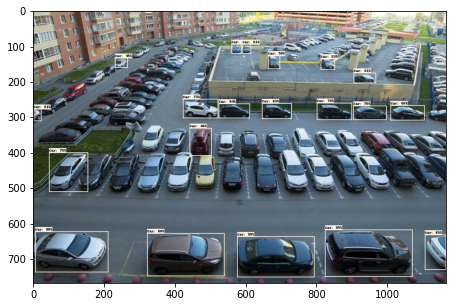

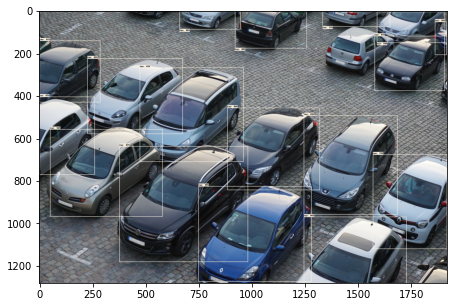

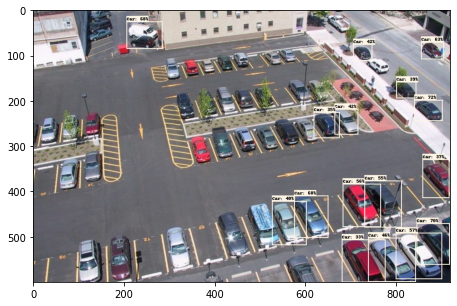

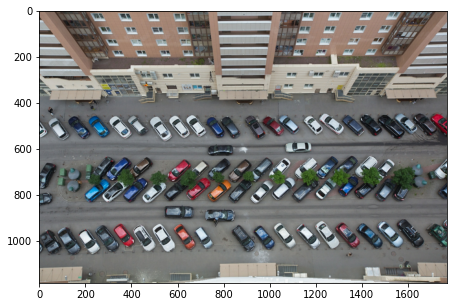

In [25]:
for name in List_name:
    image_with_boxes, result = run_detector(detector, name)
    display_image(image_with_boxes)

Что возвращает детектор:
 - detection_boxes : список из 4х (в пропорциях картинки) координат х1, у1, х2, у2 - "верхний левый" - "нижний правый" углы рамки
 - detection_class_entities - список строк с именем классов
 - detection_class_labels - список меток класса (соответствуют строкам) 

 - detection_scores - список вероятностей класса

In [26]:
result.keys()

dict_keys(['detection_boxes', 'detection_class_entities', 'detection_scores', 'detection_class_labels', 'detection_class_names'])

Резюме

Использовал ResNet на случайных картинках из поиска Яндекс по запросу парковка, с адаптацией выдачи детектора на анализ машин.  Детектор дал неплохие результаты, но уличшение требует дополнительных настроек. Можно заметить, что на результат влияет два момента:
- ракурс машины (хуже всего разпознается вид сверху)
- качество картинки (чем выше, тем лучше резултат)